In [183]:
from fastai.data.all import *
from fastai.vision.all import *
# from fastbook. import *

In [2]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cpu')

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
path.ls()

(#3) [Path('/Users/stephenzhou/.fastai/data/mnist_sample/valid'),Path('/Users/stephenzhou/.fastai/data/mnist_sample/labels.csv'),Path('/Users/stephenzhou/.fastai/data/mnist_sample/train')]

In [8]:
(path/'train').ls()

(#2) [Path('/Users/stephenzhou/.fastai/data/mnist_sample/train/7'),Path('/Users/stephenzhou/.fastai/data/mnist_sample/train/3')]

In [9]:
threes = sorted((path/'train/3').ls())

In [10]:
sevens = (path/'train/7').ls().sorted()

In [11]:
im3_path = threes[1]

In [12]:
im3 = Image.open(im3_path)

In [13]:
im3

In [14]:
array(im3).shape

(28, 28)

In [15]:
im3_t = tensor(im3)

In [16]:
df = pd.DataFrame(im3_t[4:15, 4:22])

In [17]:
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [18]:
tensors3 = [tensor(Image.open(o)) for o in threes]

In [19]:
tensors7 = [tensor(Image.open(o)) for o in sevens]

In [20]:
len(tensors3)

6131

In [21]:
len(tensors7)

6265

<Axes: >

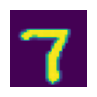

In [22]:
show_image(tensors7[0])

In [23]:
stacked_sevens = torch.stack(tensors7).float()/255

In [24]:
stacked_threes = torch.stack(tensors3).float()/255

In [25]:
stacked_threes.shape

torch.Size([6131, 28, 28])

In [26]:
mean3 = stacked_threes.mean(0)

<Axes: >

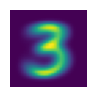

In [27]:
show_image(mean3)

In [28]:
mean7 = stacked_sevens.mean(0)

<Axes: >

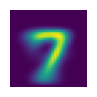

In [29]:
show_image(mean7)

In [30]:
def f(t, params):
    return params[0]*(t**2) + params[1]*t + params[2]

In [31]:
def mse(preds, targets):
    return torch.mean((preds - targets)**2)

In [32]:
params = torch.randn(3).requires_grad_()

In [33]:
params

tensor([1.6956, 1.8260, 1.1352], requires_grad=True)

In [34]:
time = torch.arange(20).float()

In [35]:
speed = torch.randn(20)*3 + 0.75 * (time - 9.5)**2 + 1

In [36]:
pred = f(time, params)

In [37]:
pred

tensor([  1.1352,   4.6567,  11.5695,  21.8734,  35.5686,  52.6550,  73.1326,
         97.0013, 124.2613, 154.9125, 188.9549, 226.3885, 267.2133, 311.4294,
        359.0366, 410.0350, 464.4246, 522.2054, 583.3774, 647.9407],
       grad_fn=<AddBackward0>)

In [38]:
speed

tensor([74.4540, 55.9899, 41.4079, 32.6954, 22.5650, 19.9118,  5.4773, -1.4987,
         2.7296, -2.1429, -0.3372,  4.6098,  1.6012,  8.4006, 14.7170, 22.1533,
        37.8807, 35.1619, 51.3825, 67.6755])

In [39]:
def show_preds(preds, ax = None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

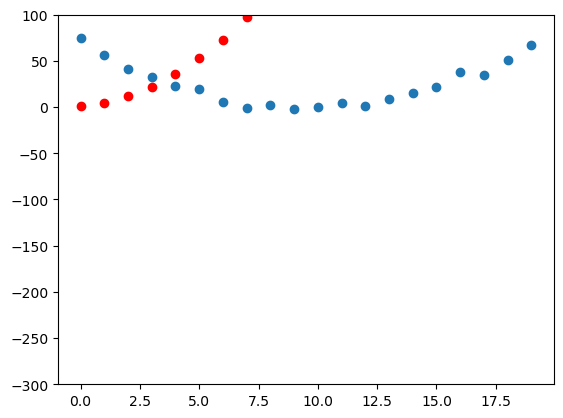

In [40]:
show_preds(pred)

In [41]:
loss = mse(pred, speed)

In [42]:
loss.backward()

In [43]:
params.grad

tensor([95029.7656,  6135.6738,   406.2937])

In [44]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= 1e-5 * params.grad
    params.grad = None
    if prn:
        print(loss.item())
    return preds

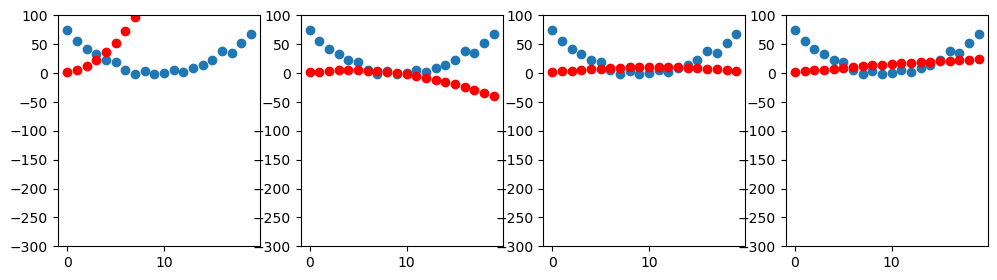

In [45]:
_, axes = plt.subplots(1,4,figsize=(12,3))
for ax in axes:
    show_preds(apply_step(params, False),ax)

In [46]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [47]:
train_x.shape

torch.Size([12396, 784])

In [48]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [49]:
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [50]:
dset = list(zip(train_x, train_y))

In [51]:
len(dset)

12396

In [52]:
x, y = dset[0]

In [53]:
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [54]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])

In [55]:
valid_3_tens = valid_3_tens.float()/255

In [56]:
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])

In [57]:
valid_7_tens = valid_7_tens.float()/255

In [58]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [59]:
valid_7_tens.shape

torch.Size([1028, 28, 28])

In [60]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)

In [61]:
valid_y = tensor(len(valid_3_tens)*[1] + len(valid_7_tens)*[0]).unsqueeze(1)

In [62]:
valid_set = list(zip(valid_x, valid_y))

In [63]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [64]:
valid_7_tens.shape

torch.Size([1028, 28, 28])

In [65]:
valid_x.shape

torch.Size([2038, 784])

In [66]:
valid_y.shape

torch.Size([2038, 1])

In [67]:
len(valid_set)

2038

In [68]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [69]:
weights = init_params((784,1))

In [70]:
bias = init_params(1)

In [71]:
(train_x[0]*weights.T).sum() + bias

tensor([-9.0280], grad_fn=<AddBackward0>)

In [72]:
def linear1(xb):
    return xb@weights + bias

In [73]:
preds = linear1(train_x)

In [74]:
preds

tensor([[ -9.0280],
        [ -7.2074],
        [ -2.7822],
        ...,
        [-10.2228],
        [-10.4630],
        [-13.6122]], grad_fn=<AddBackward0>)

In [75]:
corrects = (preds>0.5).float() == train_y

In [76]:
(corrects.sum()/len(corrects)).item()

0.5655050277709961

In [77]:
def mnist_loss(preds, targets):
    return torch.where((targets==1, 1-preds, preds).mean())

In [165]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

In [167]:
plot_function(torch.sigmoid, title = 'Sigmoid', min=-4, max=4)

NameError: name 'plot_function' is not defined